# Data & Imports

In [1]:
import autokeras as ak
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# constants
path = 'C:/Users/Asus/Documents/2023_2/Memoria/src'

# Ostar
O_df = pd.read_csv(path+'/Data/o_spectral_lines_trim.csv')
# Bstar
B_df = pd.read_csv(path+'/Data/b_spectral_lines_trim.csv')
# Observed spectra
Obs_df = pd.read_csv(path+'/Data/observed_spectral_lines_trim.csv')

Using TensorFlow backend


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

target = ['temperature','g','v']


X = B_df.drop(target,axis = 1)
Y = B_df[target]
X_obs = Obs_df.drop(target,axis=1)
Y_obs = Obs_df[target]

X = np.random.normal(loc=0, scale=0.01, size=X.shape) + X
y_scaler = MinMaxScaler()

x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.75, test_size=0.25, random_state=42)

y_scaler = y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)
y_obs = y_scaler.transform(Y_obs.values)

formatted_x_train = np.expand_dims(x_train, axis=2) #This step it's very important an CNN will only accept this data shape
formatted_x_val = np.expand_dims(x_val, axis=2)
formatted_x_test = np.expand_dims(x_test, axis=2)
formatted_x_obs = np.expand_dims(X_obs, axis=2)


c:\Users\Asus\Documents\2023_2\Memoria\py310_tf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [3]:
# Density plot function

# https://kdepy.readthedocs.io/en/latest/examples.html#minimal-working-example-with-options
from KDEpy import FFTKDE
from sklearn.neighbors import KernelDensity
import numpy as np

def SKL_density_plot(data, ax,low_bound=None,up_bound=None,title='', color='black',alpha=1,label='',kernel='gaussian', bw='silverman',linewidth=1):
  
	if low_bound != None and up_bound != None:
		bw = FFTKDE(bw=bw, kernel='gaussian').fit(data).bw
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		data = np.concatenate((data, 2 * low_bound - data, 2 * up_bound - data))
		kde = KernelDensity(bandwidth=kde.bandwidth_, kernel=kernel).fit(data.reshape(-1,1))
		x = np.linspace(low_bound,up_bound,1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		plot_y = y[np.where((x>=low_bound) & (x<=up_bound))] # Set the KDE to zero outside of the domain
		plot_x = x[np.where((x>=low_bound) & (x<=up_bound))]  # Set the KDE to zero outside of the domain
		plot_y = plot_y * 3  # Double the y-values to get integral of ~1
		ax.plot(plot_x, plot_y, label=label,color=color,alpha=alpha,linewidth=linewidth)
		return x, y, kde
	else:
		kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(data.reshape(-1,1))
		x=np.linspace(data.min(),data.max(),1000)
		y = np.exp(kde.score_samples(x.reshape(-1,1)))
		ax.plot(x, y, label=label,color=color,alpha=alpha)
		return x, y, kde

# AutoModel

In [37]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers 

#input_shape = (4, 10, 128) = (batch_size, steps, vectorLength) = (batchsize, rotaciones, frecuencias)

#normalize = layers.Normalization()

# This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1.
# It accomplishes this by precomputing the mean and variance of the data and calling (input - mean) / sqrt(var) at runtime

# TODO: Probar con los datos sin normalizar
#normalize.adapt(x_train)

input_shape = (x_train.shape[1],1)

def generate_model(): 
  return tf.keras.Sequential([
  keras.Input(shape=(input_shape)),
  #normalize,
  layers.Conv1D(32,padding="same",kernel_size=7, activation='relu'),
  layers.Conv1D(32,padding="same",kernel_size=7, activation='relu'),
  layers.MaxPooling1D(pool_size=3, padding='same'),
  layers.Conv1D(64,padding="same",kernel_size=7, activation='relu'),
  layers.Conv1D(64,padding="same",kernel_size=7, activation='relu'),
  layers.MaxPooling1D(pool_size=2, padding='same'),
  layers.GlobalAveragePooling1D(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(3, activation='linear')
])

In [59]:
def generateAutoModel():
	input = ak.Input()
	block = ak.ConvBlock()(input)
	block = ak.DenseBlock()(block)
	regression_output = ak.RegressionHead()(block)
	return ak.AutoModel(
	  inputs=input,
	  outputs=regression_output,
	  max_trials=20,
	  loss='mse',
   	metrics = 'mae'
	)

model = generateAutoModel()

Reloading Tuner from .\auto_model\tuner0.json


In [60]:
# Feed the structured auto model with training data.
#model.compile(loss = ['MSE'],
#                           optimizer = tf.optimizers.Adam(),
#                           metrics=['MAE'])
model.fit(formatted_x_train, y_train,validation_data=(formatted_x_val, y_val), epochs=20)


Trial 20 Complete [00h 08m 57s]
val_loss: 0.008693327195942402

Best val_loss So Far: 0.007894483394920826
Total elapsed time: 03h 30m 51s
Epoch 1/20
459/459 [==============================] - 28s 58ms/step - loss: 0.1174 - mae: 0.2730 - val_loss: 0.0437 - val_mae: 0.1521
Epoch 2/20
459/459 [==============================] - 27s 58ms/step - loss: 0.0338 - mae: 0.1336 - val_loss: 0.0233 - val_mae: 0.0998
Epoch 3/20
459/459 [==============================] - 27s 59ms/step - loss: 0.0209 - mae: 0.0998 - val_loss: 0.0207 - val_mae: 0.0918
Epoch 4/20
459/459 [==============================] - 27s 58ms/step - loss: 0.0180 - mae: 0.0909 - val_loss: 0.0163 - val_mae: 0.0835
Epoch 5/20
459/459 [==============================] - 27s 58ms/step - loss: 0.0157 - mae: 0.0841 - val_loss: 0.0152 - val_mae: 0.0802
Epoch 6/20
459/459 [==============================] - 27s 58ms/step - loss: 0.0149 - mae: 0.0821 - val_loss: 0.0160 - val_mae: 0.0854
Epoch 7/20
459/459 [==============================] - 27s

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [61]:
# Evaluate the best model with testing data.
evaluation = model.evaluate(formatted_x_test, y_test)

print('loss: %.3f  MAE:%.3f'% (evaluation[0],evaluation[1]))

153/153 [==============================] - 5s 32ms/step - loss: 0.0086 - mae: 0.0592
loss: 0.009  MAE:0.059


In [62]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_test))

153/153 [==============================] - 5s 30ms/step


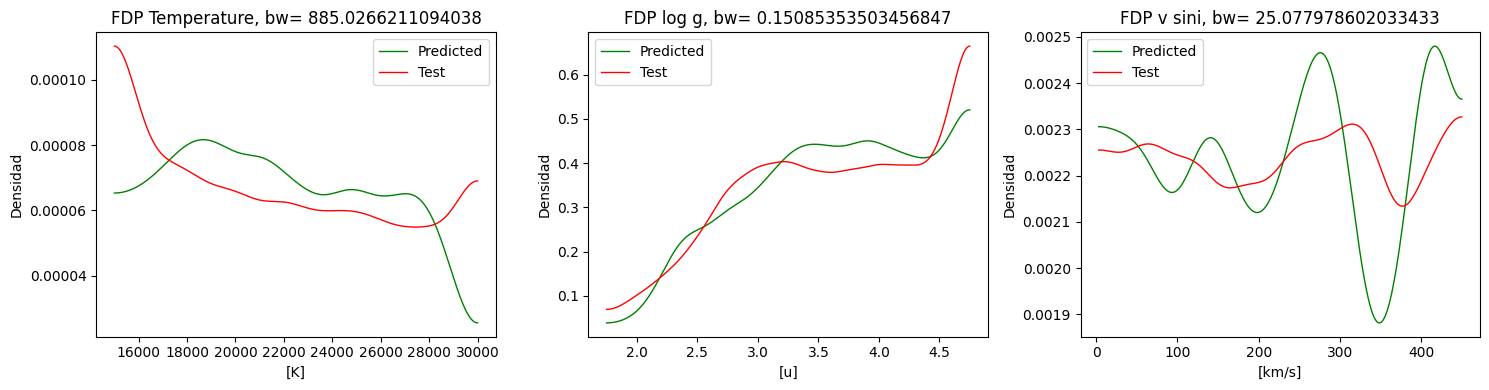

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(predictions[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Predicted')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_test)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Test')
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title('FDP '+measure[i]+', bw= '+str(kde.bandwidth_))
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

### Datos de test vs predicción (modelo único)

In [64]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
pred_error = np.abs(predictions-inverse_y_test)*(1/inverse_y_test)*100
results = pd.DataFrame({
  'Temp':inverse_y_test[:,0],'Temp_pred':predictions[:,0],'Temp_Rel_Error':pred_error[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':predictions[:,1],'log_g_Rel_Error':pred_error[:,1],
  'v':inverse_y_test[:,2],'v_pred':predictions[:,2],'v_Rel_Error':pred_error[:,2]
                    })
results.head(10)

,Temp,Temp_pred,Temp_Rel_Error,log_g,log_g_pred,log_g_Rel_Error,v,v_pred,v_Rel_Error
0,28000.0,24821.755859,11.350872,2.75,2.536214,7.774050,156.0,155.320374,0.435658
1,27000.0,27168.121094,0.622671,4.25,4.037006,5.011615,24.0,24.089424,0.372601
2,28000.0,28322.164062,1.150586,4.50,4.444541,1.232412,213.0,212.224197,0.364227
3,28000.0,28143.933594,0.514049,4.50,4.268997,5.133396,36.0,31.089050,13.641527
4,16000.0,15238.187500,4.761328,2.50,2.657487,6.299467,327.0,315.634125,3.475803
5,18000.0,17231.681641,4.268435,3.25,3.599676,10.759251,216.0,215.702332,0.137809
6,22000.0,22272.556641,1.238894,3.50,3.417906,2.345542,54.0,64.531967,19.503643
7,21000.0,18763.216797,10.651349,3.25,3.394537,4.447299,321.0,314.650604,1.978005
8,18000.0,18114.722656,0.637348,3.75,3.865424,3.077984,72.0,68.221077,5.248504
9,20000.0,19916.416016,0.417920,4.00,4.012781,0.319517,138.0,139.408142,1.020393


### Datos observados vs predicción de modelo único

In [65]:
predictions = y_scaler.inverse_transform(model.predict(formatted_x_obs))

inverse_y_obs = y_scaler.inverse_transform(y_obs)
pred_error = np.abs(predictions-inverse_y_obs)*(1/inverse_y_obs)*100
results = pd.DataFrame({
  'Temp':inverse_y_obs[:,0],'Temp_pred':predictions[:,0],'Temp_Rel_Error':pred_error[:,0],
  'log_g':inverse_y_obs[:,1],'log_g_pred':predictions[:,1],'log_g_Rel_Error':pred_error[:,1],
  'v':inverse_y_obs[:,2],'v_pred':predictions[:,2],'v_Rel_Error':pred_error[:,2]
                    })
results.head(10)



1/1 [==============================] - 0s 15ms/step


,Temp,Temp_pred,Temp_Rel_Error,log_g,log_g_pred,log_g_Rel_Error,v,v_pred,v_Rel_Error
0,15000.0,10667.453125,28.883646,3.40,3.496720,2.844708,68.0,145.655548,114.199335
1,18400.0,18669.656250,1.465523,3.50,4.675333,33.580930,40.0,92.146095,130.365238
2,30000.0,21019.859375,29.933802,3.53,2.932046,16.939202,150.0,159.570251,6.380168
3,22000.0,31032.640625,41.057457,3.90,3.836397,1.630854,280.0,345.107178,23.252563
4,24500.0,25408.359375,3.707589,3.40,3.489953,2.645678,215.0,226.371933,5.289271
5,22000.0,12643.116211,42.531290,3.50,3.513759,0.393111,180.0,247.917038,37.731688
6,20000.0,19217.138672,3.914307,3.56,2.959911,16.856430,10.0,109.723000,997.229996
7,18000.0,16631.787109,7.601183,3.53,3.707469,5.027464,250.0,247.901672,0.839331
8,26000.0,20392.123047,21.568758,2.90,2.411998,16.827654,300.0,270.639435,9.786855


In [93]:
# / TODO ponerle titulo a las cosas 
# / TODO mostrar tabla con datos sintéticos
# / TODO mostrar fdp datos sinteticos
# / TODO mostrar resultados prediccion de datos observados
# TODO distribucion predictiva de datos observados
# / TODO agregar ruido a todas las particiones de x 
# / TODO mostrar el error
# / TODO graficar comparativa de espectro observado con sintetico
# TODO entender como se llego a la red nuronal
# / TODO volver a generar instancia de entrenamiento de autokeras

# Ensemble

In [94]:
from scipy.sparse import coo_matrix
from sklearn.utils import resample

NUM_MODELS = 50
models = []
history = []

x_train_sparse = coo_matrix(x_train)

for i in range(NUM_MODELS):
	am = generateAutoModel()
	x_train_resampled, x_train_sparse, y_train_resampled = resample(x_train, x_train_sparse, y_train, random_state=i)
	x_train_resampled = np.expand_dims(x_train_resampled, axis=2)
	history.append(am.fit(x=x_train_resampled, y=y_train_resampled, epochs=20))
	models.append(am.export_model())

Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2639 - mse: 0.0987
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2415 - mse: 0.0805
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2130 - mse: 0.0681
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1927 - mse: 0.0588
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1767 - mse: 0.0518
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1617 - mse: 0.0460
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1502 - mse: 0.0414
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1423 - mse: 0.0386
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1363 - mse: 0.0364
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1322 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2619 - mse: 0.0969
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2395 - mse: 0.0798
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2101 - mse: 0.0673
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1909 - mse: 0.0581
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1735 - mse: 0.0506
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1587 - mse: 0.0448
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1485 - mse: 0.0409
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1406 - mse: 0.0379
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1352 - mse: 0.0360
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1309 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2619 - mse: 0.0971
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2416 - mse: 0.0805
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2126 - mse: 0.0675
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1879 - mse: 0.0562
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1707 - mse: 0.0489
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1560 - mse: 0.0432
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1442 - mse: 0.0390
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1362 - mse: 0.0361
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1299 - mse: 0.0341
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1246 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2628 - mse: 0.0973
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2318 - mse: 0.0757
Epoch 3/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1943 - mse: 0.0593
Epoch 4/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1718 - mse: 0.0496
Epoch 5/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1529 - mse: 0.0423
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1415 - mse: 0.0382
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1341 - mse: 0.0358
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1281 - mse: 0.0338
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1233 - mse: 0.0325
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1192 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2651 - mse: 0.1000
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2429 - mse: 0.0809
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2201 - mse: 0.0707
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1980 - mse: 0.0612
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1831 - mse: 0.0543
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1685 - mse: 0.0482
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1543 - mse: 0.0427
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1431 - mse: 0.0387
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1361 - mse: 0.0361
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1300 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2651 - mse: 0.0994
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2429 - mse: 0.0812
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2148 - mse: 0.0687
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1947 - mse: 0.0596
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1803 - mse: 0.0530
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1650 - mse: 0.0471
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1524 - mse: 0.0422
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1437 - mse: 0.0391
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1358 - mse: 0.0365
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1314 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2634 - mse: 0.0986
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2418 - mse: 0.0808
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2231 - mse: 0.0728
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2080 - mse: 0.0663
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1997 - mse: 0.0621
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1910 - mse: 0.0576
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1807 - mse: 0.0528
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1653 - mse: 0.0465
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1512 - mse: 0.0413
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1412 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2666 - mse: 0.1016
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2405 - mse: 0.0799
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2113 - mse: 0.0672
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1909 - mse: 0.0580
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1769 - mse: 0.0520
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1624 - mse: 0.0461
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1510 - mse: 0.0417
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1422 - mse: 0.0383
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1354 - mse: 0.0358
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1307 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2625 - mse: 0.0980
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2383 - mse: 0.0786
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2079 - mse: 0.0656
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1888 - mse: 0.0569
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1734 - mse: 0.0500
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1581 - mse: 0.0442
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1466 - mse: 0.0398
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1394 - mse: 0.0373
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1326 - mse: 0.0351
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1277 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2665 - mse: 0.1017
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2381 - mse: 0.0786
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2039 - mse: 0.0637
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1836 - mse: 0.0545
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1654 - mse: 0.0467
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1513 - mse: 0.0414
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1418 - mse: 0.0379
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1351 - mse: 0.0358
Epoch 9/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1306 - mse: 0.0340
Epoch 10/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1273 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2668 - mse: 0.1016
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2409 - mse: 0.0797
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2063 - mse: 0.0646
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1838 - mse: 0.0542
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1624 - mse: 0.0456
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1478 - mse: 0.0402
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1382 - mse: 0.0366
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1318 - mse: 0.0346
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1270 - mse: 0.0330
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1220 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2651 - mse: 0.1001
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2379 - mse: 0.0784
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1998 - mse: 0.0620
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1779 - mse: 0.0522
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1604 - mse: 0.0453
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1486 - mse: 0.0411
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1411 - mse: 0.0382
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1355 - mse: 0.0362
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1315 - mse: 0.0350
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1283 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2592 - mse: 0.0949
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2401 - mse: 0.0799
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2141 - mse: 0.0688
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1962 - mse: 0.0606
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1832 - mse: 0.0544
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1692 - mse: 0.0486
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1566 - mse: 0.0439
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1473 - mse: 0.0405
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1405 - mse: 0.0378
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1353 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2659 - mse: 0.1008
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2347 - mse: 0.0771
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1976 - mse: 0.0612
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1761 - mse: 0.0515
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1581 - mse: 0.0444
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1463 - mse: 0.0398
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1383 - mse: 0.0369
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1322 - mse: 0.0348
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1275 - mse: 0.0334
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1235 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2645 - mse: 0.0999
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2399 - mse: 0.0798
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2122 - mse: 0.0678
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1932 - mse: 0.0589
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1791 - mse: 0.0524
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1645 - mse: 0.0468
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1508 - mse: 0.0415
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1411 - mse: 0.0380
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1333 - mse: 0.0356
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1277 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2681 - mse: 0.1025
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2376 - mse: 0.0782
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1960 - mse: 0.0604
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1771 - mse: 0.0517
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1607 - mse: 0.0452
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1489 - mse: 0.0407
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1388 - mse: 0.0369
Epoch 8/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1321 - mse: 0.0347
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1275 - mse: 0.0331
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1228 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2649 - mse: 0.1001
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2334 - mse: 0.0765
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2021 - mse: 0.0631
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1823 - mse: 0.0540
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1627 - mse: 0.0460
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1483 - mse: 0.0406
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1371 - mse: 0.0367
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1295 - mse: 0.0344
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1230 - mse: 0.0325
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1188 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2662 - mse: 0.1011
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2376 - mse: 0.0783
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2004 - mse: 0.0624
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1802 - mse: 0.0530
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1621 - mse: 0.0459
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1499 - mse: 0.0412
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1422 - mse: 0.0384
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1371 - mse: 0.0366
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1327 - mse: 0.0350
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1291 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2641 - mse: 0.0988
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2385 - mse: 0.0788
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1980 - mse: 0.0612
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1750 - mse: 0.0510
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1570 - mse: 0.0439
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1440 - mse: 0.0392
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1352 - mse: 0.0361
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1294 - mse: 0.0341
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1238 - mse: 0.0326
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1193 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2653 - mse: 0.1007
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2390 - mse: 0.0791
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2045 - mse: 0.0640
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1832 - mse: 0.0542
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1674 - mse: 0.0479
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1546 - mse: 0.0430
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1455 - mse: 0.0395
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1385 - mse: 0.0371
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1337 - mse: 0.0354
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1304 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2642 - mse: 0.0993
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2377 - mse: 0.0783
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1985 - mse: 0.0614
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1766 - mse: 0.0516
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1591 - mse: 0.0447
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1463 - mse: 0.0397
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1378 - mse: 0.0366
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1306 - mse: 0.0341
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1250 - mse: 0.0325
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1202 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2624 - mse: 0.0976
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2416 - mse: 0.0804
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2146 - mse: 0.0683
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1939 - mse: 0.0592
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1818 - mse: 0.0536
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1659 - mse: 0.0470
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1523 - mse: 0.0418
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1410 - mse: 0.0379
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1339 - mse: 0.0356
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1275 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2639 - mse: 0.0987
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2403 - mse: 0.0796
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2070 - mse: 0.0651
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1835 - mse: 0.0545
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1655 - mse: 0.0472
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1519 - mse: 0.0419
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1424 - mse: 0.0382
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1351 - mse: 0.0355
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1302 - mse: 0.0338
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1258 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2678 - mse: 0.1031
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2353 - mse: 0.0772
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1968 - mse: 0.0604
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1681 - mse: 0.0482
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1502 - mse: 0.0411
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1392 - mse: 0.0371
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1313 - mse: 0.0346
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1247 - mse: 0.0326
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1193 - mse: 0.0311
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1165 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2604 - mse: 0.0952
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2402 - mse: 0.0800
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2092 - mse: 0.0666
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1900 - mse: 0.0576
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1747 - mse: 0.0507
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1613 - mse: 0.0455
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1505 - mse: 0.0415
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1432 - mse: 0.0387
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1375 - mse: 0.0366
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1333 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2639 - mse: 0.0996
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2388 - mse: 0.0791
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2094 - mse: 0.0666
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1913 - mse: 0.0580
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1747 - mse: 0.0508
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1601 - mse: 0.0450
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1494 - mse: 0.0407
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1415 - mse: 0.0379
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1361 - mse: 0.0361
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1313 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2656 - mse: 0.1004
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2410 - mse: 0.0800
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2052 - mse: 0.0643
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1775 - mse: 0.0520
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1545 - mse: 0.0428
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1400 - mse: 0.0378
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1313 - mse: 0.0349
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1249 - mse: 0.0330
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1200 - mse: 0.0316
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1166 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2609 - mse: 0.0956
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2379 - mse: 0.0785
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2022 - mse: 0.0631
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1858 - mse: 0.0555
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1718 - mse: 0.0497
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1594 - mse: 0.0447
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1483 - mse: 0.0406
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1405 - mse: 0.0380
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1336 - mse: 0.0356
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1280 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2613 - mse: 0.0958
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2428 - mse: 0.0810
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2144 - mse: 0.0682
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1913 - mse: 0.0579
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1770 - mse: 0.0514
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1623 - mse: 0.0456
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1508 - mse: 0.0414
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1433 - mse: 0.0386
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1377 - mse: 0.0367
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1337 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 13ms/step - loss: 0.2657 - mse: 0.1008
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2400 - mse: 0.0798
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2005 - mse: 0.0623
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1821 - mse: 0.0538
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1659 - mse: 0.0470
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1525 - mse: 0.0420
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1422 - mse: 0.0381
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1350 - mse: 0.0356
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1293 - mse: 0.0338
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1244 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2640 - mse: 0.0991
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2328 - mse: 0.0759
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1883 - mse: 0.0564
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1648 - mse: 0.0466
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1479 - mse: 0.0403
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1367 - mse: 0.0363
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1297 - mse: 0.0340
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1253 - mse: 0.0327
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1203 - mse: 0.0314
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1167 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2643 - mse: 0.0995
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2412 - mse: 0.0802
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2091 - mse: 0.0658
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1866 - mse: 0.0557
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1699 - mse: 0.0487
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1547 - mse: 0.0431
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1437 - mse: 0.0390
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1363 - mse: 0.0363
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1293 - mse: 0.0342
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1243 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2645 - mse: 0.0992
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2426 - mse: 0.0808
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2141 - mse: 0.0681
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1904 - mse: 0.0574
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1725 - mse: 0.0495
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1550 - mse: 0.0427
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1420 - mse: 0.0381
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1330 - mse: 0.0354
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1270 - mse: 0.0336
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1227 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2611 - mse: 0.0961
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2420 - mse: 0.0809
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2131 - mse: 0.0682
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1928 - mse: 0.0586
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1746 - mse: 0.0506
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1593 - mse: 0.0445
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1484 - mse: 0.0402
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1406 - mse: 0.0374
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1349 - mse: 0.0354
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1306 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2621 - mse: 0.0974
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2362 - mse: 0.0775
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1996 - mse: 0.0616
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1754 - mse: 0.0506
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1548 - mse: 0.0425
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1406 - mse: 0.0376
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1313 - mse: 0.0345
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1245 - mse: 0.0326
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1207 - mse: 0.0315
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1169 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2651 - mse: 0.1003
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2352 - mse: 0.0771
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1937 - mse: 0.0591
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1714 - mse: 0.0492
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1551 - mse: 0.0429
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1444 - mse: 0.0389
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1371 - mse: 0.0363
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1320 - mse: 0.0345
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1279 - mse: 0.0332
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1242 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2647 - mse: 0.0994
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2432 - mse: 0.0814
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2207 - mse: 0.0716
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2022 - mse: 0.0633
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1912 - mse: 0.0579
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1779 - mse: 0.0519
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1658 - mse: 0.0472
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1544 - mse: 0.0428
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1456 - mse: 0.0394
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1388 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2645 - mse: 0.1000
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2382 - mse: 0.0788
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2016 - mse: 0.0630
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1844 - mse: 0.0548
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1685 - mse: 0.0478
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1536 - mse: 0.0424
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1433 - mse: 0.0386
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1354 - mse: 0.0358
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1293 - mse: 0.0339
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1237 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2629 - mse: 0.0982
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2411 - mse: 0.0803
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2075 - mse: 0.0653
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1850 - mse: 0.0552
Epoch 5/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1676 - mse: 0.0480
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1538 - mse: 0.0426
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1448 - mse: 0.0393
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1386 - mse: 0.0371
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1339 - mse: 0.0355
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1306 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2652 - mse: 0.1000
Epoch 2/20
459/459 [==============================] - 6s 14ms/step - loss: 0.2372 - mse: 0.0782
Epoch 3/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1971 - mse: 0.0607
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1769 - mse: 0.0516
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1606 - mse: 0.0451
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1502 - mse: 0.0412
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1421 - mse: 0.0381
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1370 - mse: 0.0366
Epoch 9/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1328 - mse: 0.0351
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1298 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2579 - mse: 0.0936
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2397 - mse: 0.0798
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2114 - mse: 0.0676
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1904 - mse: 0.0577
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1725 - mse: 0.0501
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1586 - mse: 0.0446
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1489 - mse: 0.0409
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1418 - mse: 0.0382
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1368 - mse: 0.0363
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1325 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2648 - mse: 0.1006
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2417 - mse: 0.0808
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2171 - mse: 0.0698
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2010 - mse: 0.0626
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1887 - mse: 0.0566
Epoch 6/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1725 - mse: 0.0494
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1569 - mse: 0.0432
Epoch 8/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1457 - mse: 0.0389
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1373 - mse: 0.0360
Epoch 10/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1303 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2668 - mse: 0.1015
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2388 - mse: 0.0787
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1997 - mse: 0.0618
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1765 - mse: 0.0516
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1579 - mse: 0.0444
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1460 - mse: 0.0398
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1378 - mse: 0.0368
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1317 - mse: 0.0346
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1267 - mse: 0.0329
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1228 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2589 - mse: 0.0945
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2370 - mse: 0.0781
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1994 - mse: 0.0616
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1793 - mse: 0.0525
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1629 - mse: 0.0459
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1507 - mse: 0.0414
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1412 - mse: 0.0378
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1348 - mse: 0.0355
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1300 - mse: 0.0341
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1260 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2657 - mse: 0.1006
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2408 - mse: 0.0799
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2052 - mse: 0.0643
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1805 - mse: 0.0532
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1609 - mse: 0.0454
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1471 - mse: 0.0400
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1370 - mse: 0.0365
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1301 - mse: 0.0342
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1246 - mse: 0.0327
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1205 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2660 - mse: 0.1013
Epoch 2/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2391 - mse: 0.0792
Epoch 3/20
459/459 [==============================] - 6s 13ms/step - loss: 0.2075 - mse: 0.0655
Epoch 4/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1886 - mse: 0.0568
Epoch 5/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1717 - mse: 0.0495
Epoch 6/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1567 - mse: 0.0436
Epoch 7/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1464 - mse: 0.0398
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1383 - mse: 0.0369
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1313 - mse: 0.0345
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1261 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2650 - mse: 0.0990
Epoch 2/20
459/459 [==============================] - 6s 14ms/step - loss: 0.2430 - mse: 0.0813
Epoch 3/20
459/459 [==============================] - 6s 14ms/step - loss: 0.2134 - mse: 0.0680
Epoch 4/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1913 - mse: 0.0580
Epoch 5/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1744 - mse: 0.0506
Epoch 6/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1579 - mse: 0.0442
Epoch 7/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1469 - mse: 0.0400
Epoch 8/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1387 - mse: 0.0372
Epoch 9/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1328 - mse: 0.0353
Epoch 10/20
459/459 [==============================] - 6s 13ms/step - loss: 0.1270 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2597 - mse: 0.0957
Epoch 2/20
459/459 [==============================] - 6s 14ms/step - loss: 0.2341 - mse: 0.0765
Epoch 3/20
459/459 [==============================] - 6s 14ms/step - loss: 0.2052 - mse: 0.0646
Epoch 4/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1872 - mse: 0.0560
Epoch 5/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1663 - mse: 0.0469
Epoch 6/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1502 - mse: 0.0408
Epoch 7/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1399 - mse: 0.0369
Epoch 8/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1339 - mse: 0.0348
Epoch 9/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1283 - mse: 0.0329
Epoch 10/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1249 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2640 - mse: 0.0996
Epoch 2/20
459/459 [==============================] - 6s 14ms/step - loss: 0.2408 - mse: 0.0801
Epoch 3/20
459/459 [==============================] - 6s 14ms/step - loss: 0.2147 - mse: 0.0687
Epoch 4/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1943 - mse: 0.0595
Epoch 5/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1806 - mse: 0.0531
Epoch 6/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1678 - mse: 0.0479
Epoch 7/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1538 - mse: 0.0426
Epoch 8/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1438 - mse: 0.0391
Epoch 9/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1360 - mse: 0.0363
Epoch 10/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1298 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Reloading Tuner from .\auto_model\tuner0.json
Epoch 1/20
459/459 [==============================] - 7s 14ms/step - loss: 0.2636 - mse: 0.0984
Epoch 2/20
459/459 [==============================] - 6s 14ms/step - loss: 0.2449 - mse: 0.0824
Epoch 3/20
459/459 [==============================] - 6s 14ms/step - loss: 0.2203 - mse: 0.0712
Epoch 4/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1971 - mse: 0.0611
Epoch 5/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1814 - mse: 0.0536
Epoch 6/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1660 - mse: 0.0475
Epoch 7/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1539 - mse: 0.0427
Epoch 8/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1448 - mse: 0.0394
Epoch 9/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1383 - mse: 0.0371
Epoch 10/20
459/459 [==============================] - 6s 14ms/step - loss: 0.1338 - mse: 

INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


In [111]:
# prediccion de datos observados
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_test)) for model in models]) # dim(predictions) = (num_models, num_rows, num_outputs)

  1/153 [..............................] - ETA: 3s

153/153 [==============================] - 1s 5ms/step


In [112]:
# prediccion del ensamble e incerteza
weights = [model.evaluate(formatted_x_test, y_test)[0] for model in models]
weights = [weight/sum(weights) for weight in weights]

ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)


153/153 [==============================] - 1s 6ms/step - loss: 0.1047 - mse: 0.0272


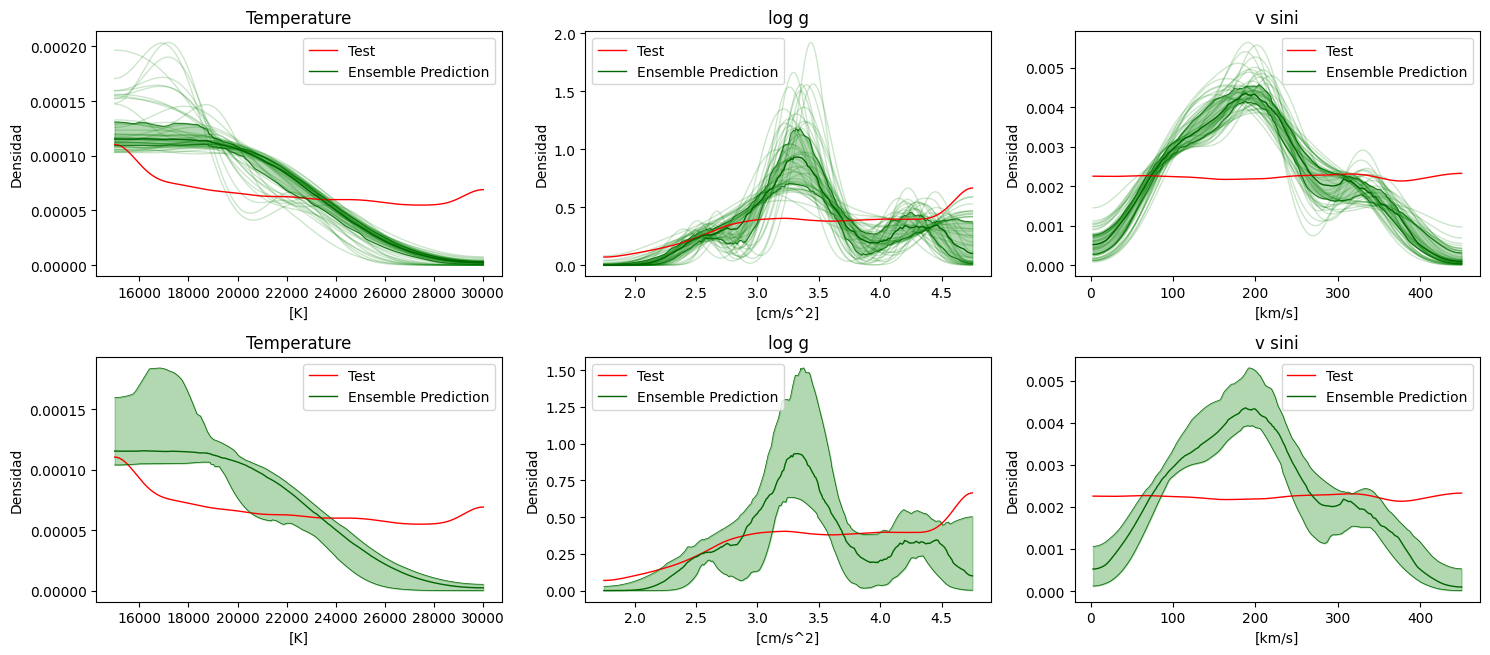

In [119]:
# Ref: https://stackoverflow.com/questions/60130503/plotting-bars-hist-and-pdf-line-via-kdeplot
import scipy.stats as st
from scipy.interpolate import interp1d

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,6.66))

for i, featureName in enumerate(target):
	x_space = np.linspace(Y[featureName].min(), Y[featureName].max(), 2**12)
	heights = []
	for j in range(NUM_MODELS):
		prediction_y = predictions[j,:,i] # your data goes here
		x,y,prediction_kde = SKL_density_plot(prediction_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',alpha=0.2)
		f = interp1d(x, y, kind="linear", assume_sorted=True)
		h = f(x_space)*3
		heights.append(h)
  
	heights = np.array(heights)
 
	rescaled_y = y_scaler.inverse_transform(y_test)[:,i]
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[0,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	x,y,test_kde = SKL_density_plot(rescaled_y, axes[1,i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'red',label='Test')
	f = interp1d(x, y, kind="linear", assume_sorted=True)
	test_h = f(x_space)
 
	# cuantiles 50% de los datos
	q25 = np.quantile(heights,0.25,axis=0)
	q75 = np.quantile(heights,0.75,axis=0)
	axes[0,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[0,i].plot(x_space, q25,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].plot(x_space, q75,color='darkGreen',alpha=1,linewidth=0.5)
	axes[0,i].fill_between(x_space, q25,q75, alpha=0.30, color='green')
	
	# cuantiles 95% de los datos
	q5 = np.quantile(heights,0.05,axis=0)
	q95 = np.quantile(heights,0.95,axis=0)
	axes[1,i].plot(x_space, np.median(heights,axis=0),color='darkGreen',alpha=1,linewidth=1,label='Ensemble Prediction')
	axes[1,i].plot(x_space, q5,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].plot(x_space, q95,color='darkGreen',alpha=1,linewidth=0.5)
	axes[1,i].fill_between(x_space, q5,q95, alpha=0.30, color='green')
	
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[cm/s^2]', '[km/s]']
	axes[1,i].set_xlabel(measure_unit[i])
	axes[1,i].set_ylabel('Densidad')
	axes[1,i].legend()
	axes[1,i].set_title(measure[i])

	axes[0,i].set_xlabel(measure_unit[i])
	axes[0,i].set_ylabel('Densidad')
	axes[0,i].legend()
	axes[0,i].set_title(measure[i])


plt.tight_layout()
plt.show()

### Datos de test vs predicción (ensamble)

In [114]:
# dataframe
inverse_y_test = y_scaler.inverse_transform(y_test)
results = pd.DataFrame({
  'Temp':inverse_y_test[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_test[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_test[:,2],'v_pred':ensemble_prediction[:,2],'v_Variance':uncertainty[:,2]
                    })
results.head(10)

,Temp,Temp_pred,Temp_Variance,log_g,log_g_pred,log_g_Variance,v,v_pred,v_Variance
0,28000.0,14566.492188,788.151611,2.75,1.775527,0.108968,156.0,158.061310,7.442987
1,27000.0,29122.025391,426.271790,4.25,4.230992,0.170341,24.0,24.673529,12.139290
2,28000.0,23640.562500,889.908203,4.50,4.051013,0.131762,213.0,191.273010,9.276322
3,28000.0,27509.517578,521.075806,4.50,4.360466,0.122449,36.0,41.500534,6.915040
4,16000.0,16951.562500,902.318115,2.50,2.948545,0.125826,327.0,330.971558,8.599333
5,18000.0,18002.753906,525.155396,3.25,3.363375,0.088170,216.0,198.973083,15.209253
6,22000.0,22158.072266,538.147461,3.50,3.711950,0.078657,54.0,45.956303,6.276753
7,21000.0,21296.929688,750.441467,3.25,3.648381,0.101337,321.0,333.869934,8.560051
8,18000.0,18140.802734,373.249695,3.75,3.786808,0.068436,72.0,51.746071,5.818358
9,20000.0,19603.492188,529.126282,4.00,4.196813,0.078978,138.0,120.526779,6.573854


### Datos observados vs predicción (ensamble)

In [115]:
# generar predicciones e incerteza de ensamble
predictions = np.array([y_scaler.inverse_transform(model.predict(formatted_x_obs)) for model in models])
ensemble_prediction = sum([predictions[i]*weights[i] for i in range(len(models))])
uncertainty = sum([(predictions[i]-ensemble_prediction)**2*weights[i] for i in range(len(models))])**(1/2)

1/1 [==============================] - 0s 19ms/step


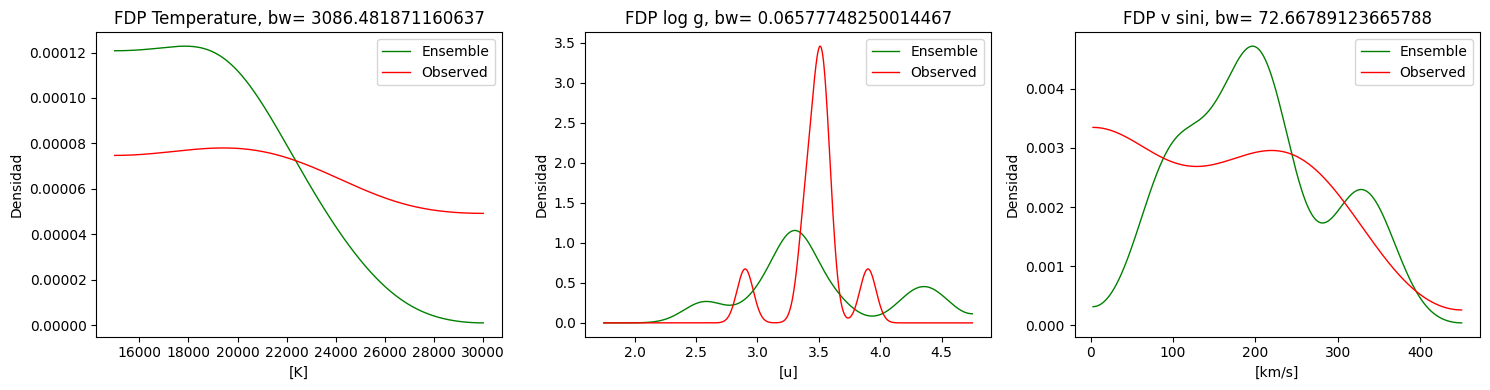

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

for i, featureName in enumerate(target):
	x, y, kde = SKL_density_plot(ensemble_prediction[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color = 'green',label='Ensemble')
	x, y, kde = SKL_density_plot(y_scaler.inverse_transform(y_obs)[:,i], axes[i], low_bound=Y.iloc[:,i].min(),up_bound=Y.iloc[:,i].max(), color='red',label='Observed')
	measure = ['Temperature','log g', 'v sini']
	measure_unit = ['[K]', '[u]', '[km/s]']
	axes[i].set_xlabel(measure_unit[i])
	axes[i].set_ylabel('Densidad')
	axes[i].set_title('FDP '+measure[i]+', bw= '+str(kde.bandwidth_))
	axes[i].legend()

plt.legend()
plt.tight_layout();
plt.show()

In [117]:
# dataframe comparativo de datos observados
inverse_y_obs = y_scaler.inverse_transform(y_obs)
results = pd.DataFrame({
  'Temp':inverse_y_obs[:,0],'Temp_pred':ensemble_prediction[:,0],'Temp_Variance':uncertainty[:,0],
  'log_g':inverse_y_obs[:,1],'log_g_pred':ensemble_prediction[:,1],'log_g_Variance':uncertainty[:,1],
  'v':inverse_y_obs[:,2],'v_pred':ensemble_prediction[:,2],'v_Rel_Variance':uncertainty[:,2]
                    })
results.head(10)

,Temp,Temp_pred,Temp_Variance,log_g,log_g_pred,log_g_Variance,v,v_pred,v_Rel_Variance
0,15000.0,14082.674805,958.765503,3.40,3.270938,0.145557,68.0,140.602127,8.225054
1,18400.0,20198.505859,1875.074219,3.50,4.444441,0.176287,40.0,98.759895,11.963840
2,30000.0,19149.130859,581.222656,3.53,3.027949,0.170520,150.0,178.203674,18.510866
3,22000.0,23732.046875,893.269043,3.90,4.266267,0.140805,280.0,338.343475,29.659458
4,24500.0,21821.794922,740.404541,3.40,3.322892,0.182325,215.0,210.532333,17.044737
5,22000.0,12677.030273,704.862061,3.50,3.310708,0.090783,180.0,216.162933,8.792626
6,20000.0,19041.343750,816.597412,3.56,3.324661,0.090069,10.0,86.714699,12.497373
7,18000.0,15691.710938,539.241516,3.53,3.607934,0.116446,250.0,206.754608,7.073198
8,26000.0,19445.685547,1180.118042,2.90,2.569084,0.105129,300.0,321.698334,10.475869


In [118]:
# TODO revisar drive con datos de estrellas pucheros
# TODO hacer tabla comparativa con valores predichos y comparar con tabla del paper
# TODO revisar parametros para probar con autokeras
# TODO corregir graficos, intervalo de confianza(25%) + distribuciones puntuales, intervalo de confianza 95% sin distribuciones puntuales
# TODO scatter de valor observado/testing vs prediccion 3 graficos
# TODO corregir en vez de varianza, std dev